In [1]:
import matplotlib.pyplot as plt
import os
from numpy import load, arange, random, float32, save, ones, zeros_like, zeros, array
from sklearn.decomposition import PCA

cupy is the CUDA version of numpy, they can replace each other in almost circumstance. 
https://docs.cupy.dev/en/stable/install.html 

If you don't have cuda environment, please import numpy as cp. Remind numpy will be 70~700 times slower than cupy(depend on your graphic card). 
The scikit's implement is much more efficient than mine. I am figuring it out why.

Choose cupy or numpy to use

import cupy as cp

In [2]:
import numpy as cp

# Config

In [3]:
SAMPLE_SIZE = 800
BATCH_SIZE = 800
BATCH_PER_EPOCH = SAMPLE_SIZE//BATCH_SIZE
P_DIM = 32
Q_DIM = 2
PERP = 30 #5~40 works fine
CLASS = 10
EPOCH = 100
RECORD_KL = True

Q_SUM_IN_RAW = False #True get more local results
G_CORRECT = True     #False in t-sne paper
P_SYMMETRIC = True

In [4]:
def LR(t, init = 0.5):
    return init

def momentum(t, init = 0.65):
    return init

In [5]:
saving_adr = 'data/' + str(SAMPLE_SIZE)
try:
    os.mkdir(saving_adr)
except FileExistsError:
    print(saving_adr, " has already exists")
    
result_adr = 'result/' + str(SAMPLE_SIZE)
if Q_SUM_IN_RAW:
    result_adr+= '_QSIR'
if G_CORRECT:
    result_adr+= '_GC'
if P_SYMMETRIC:
    result_adr+= '_PS'
    
try:
    os.mkdir(result_adr)
except FileExistsError:
    print(result_adr, " has already exists")


data/800  has already exists
result/800_GC_PS  has already exists


# Plotting function

In [6]:
def classifier(y, LB):
    return [y[LB[i]] for i in range(CLASS)]

def scatter_plot(YL, name, folder = result_adr):
    for i in range(CLASS):
        temp = YL[i].transpose()
        plt.scatter(temp[0], temp[1], s = 3)
        plt.text(sum(temp[0])/len(temp[0]), sum(temp[1])/len(temp[1]), str(i), size = 24)
    plt.savefig(folder+ "/" + name+ '.png')
    plt.show()

# Loading data and Preprocessing

In [7]:
def Import_mnist(MNIST_address = 'data/mnist.npz'):
    mnist_npz = load(MNIST_address)
    
    return (
        (mnist_npz['x_train'], mnist_npz['y_train']),
        (mnist_npz['x_test'], mnist_npz['y_test'])
    )

def classify_index(LabeL):#classify label by 0~9
    temp = [[] for i in range(CLASS)]
    count = 0
    for i in LabeL:
        temp[i].append(count)
        count+=1
    return temp

In [8]:
def read_data():
    training_data, testing_data = Import_mnist() #testing data will be dropped
    picture, label = training_data
    print("Load MNIST success")
    print("Picture size:", picture.shape, "| Label size:", label.shape)
    
    #Sample of 0~9, plot by 5*2 pictures
    fig, axes = plt.subplots(2, 5, figsize=(7, 6))
    ax = list(axes.ravel())
    j=0
    i=0
    for k in range(10):
        while(label[i]!=j):
            i+=1
        ax[k].imshow(picture[i,])
        ax[k].set_title(str(j))
        ax[k].axis("off")
        j+=1
    plt.show()
    
    #cut data into desired size with radomly index
    ll = arange(picture.shape[0])
    random.shuffle(ll)

    print("cut 60000 into ", SAMPLE_SIZE)
    x = picture[ll[:SAMPLE_SIZE]]
    label = label[ll[:SAMPLE_SIZE]]
    
    #flatten picture and convert dtype from int(0~255) into float(0~1)
    x = (x.reshape((SAMPLE_SIZE, -1))/255.).astype(float32) 
    print("the shape of data after cut and flatten: ", x.shape)
    
    #from (Sample_size, 28*28) to (Sample_size, P_DIM)
    pca = PCA(n_components= P_DIM) 
    x = pca.fit_transform(x)
    print("the shape of data after PCA: ", x.shape)
    
    #classify label by 0~9
    indexes = classify_index(label)
    
    return x, indexes

# t_SNE

In [9]:
#x.shape = (Sample_size, P_dim)
def dist_matrix(x):
    A = x.reshape((x.shape[0], 1, x.shape[-1])) #(Sample_size, 1, P_dim)
    A = cp.tile(A, (1, A.shape[0], 1))          #(Sample_size, Sample_size, P_dim)
    A_t = A.transpose((1,0,2))
    
    return A-A_t

$a_{i}$(x) :=
exp($\frac{- \left\| x_{i} - \ x \right\|^{2}}{{2\delta}_{i}^{2}}$)
(normal dist)

$p_{j|i}$ := $\frac{a_{i}(x_{j})}{\sum_{k \neq i\ }^{}{a_{i}(x_{k})}}$

$p_{ij}$ := $\frac{p_{j|i} + p_{i|j}}{2}$
(symmetric)


In [10]:
def count_Pij(sigma, x):                        #(Sample_size, P_dim)
    dist_x = dist_matrix(x)                     #(Sample_size, Sample_size, P_dim)
    norm_x = cp.sum(dist_x**2, axis = -1)       #(Sample_size, Sample_size)
    
    sigma = sigma.reshape((-1, 1))
    A_ij = cp.exp(-norm_x/sigma ) 
    for i in range(x.shape[0]):
        A_ij[i][i] = 0

    P_ij = A_ij/(cp.sum(A_ij, axis = -1).reshape((-1,1)))
    return P_ij

$b_{i}$(y) := ${(1 + \left\| y_{i} - \text{ y} \right\|^{2})}^{- 1}$
(t dist)

$q_{ij}$ := $\frac{b_{i}(y_{j})}{\sum_{k \neq m\ }^{}{b_{m}(y_{k})}}$


In [11]:
def count_Qij(y):
    dist_y = cp.asarray(dist_matrix(y)) #(SAMPLE_SIZE, SAMPLE_SIZE, 2)
    
    B_ij = dist_y**2
    B_ij = 1/(1 + cp.sum(B_ij, axis = -1)) #(SAMPLE_SIZE, SAMPLE_SIZE)
    
    for i in range(y.shape[0]):
        B_ij[i][i] = 0
    
    if Q_SUM_IN_RAW:
        Q_ij = B_ij/(cp.sum(B_ij, axis = 1).reshape((-1,1)))
    else:
        Q_ij = B_ij/(cp.sum(B_ij))
    
    return dist_y, B_ij, Q_ij

# Search of sigma_i

${H(P) :=\sum_{j}^{}{p_{j}log_{2}(p_{j})}}$

In [12]:
def H_P(sigma, x):
    P = count_Pij(sigma, x)
    return -cp.sum(P*cp.log2(P+ 1e-8), axis = 1)#(Sample_size, 1)

def Bisection(maxi, mini, sigma, booling, in_range):
    if in_range:
        if booling:
            return [sigma, mini]
        else:
            return [maxi, sigma]
    else:
        return [mini, mini/2]

def find_sigma(perp, x, times = 20):
    print("\nStart Binary searching for sigma_i:\nPerplexity: ", perp, " | Binary searching for ", times, " times")
    H = cp.log2(perp)
    
    sigma_max = 600*ones(SAMPLE_SIZE)
    sigma_min = 1.8*ones(SAMPLE_SIZE)
    
    
    for i in range(times):
        sigma_mid = (sigma_max + sigma_min)/2

        booling = H_P(sigma_mid, x)>=H
        in_range = H_P(sigma_min, x)<H
        
        temp = cp.array(list(map(Bisection, sigma_max, sigma_min, sigma_mid, booling, in_range))).T

        sigma_max = temp[0]
        sigma_min = temp[1]
        
        
        ratio = int((i+1)/times*40)
        print("[", "#"*ratio, "-"*(40-ratio), "] ", i, " in ", times, end='\r')

    return (sigma_max + sigma_min)/2



# Fitting

C := KL(P\|\|Q) =
$\sum_{i}^{}{\sum_{j}^{}{p_{ij}log(\frac{p_{ij}}{q_{ij}})}}$ (cost)


In [13]:
def KL(P, Q): #KL(P||Q)
    return cp.sum(P*cp.log2(P/(Q + 1e-6) + 1e-6))

$\frac{\partial C}{\partial y_{i}}$ =
4$\sum_{j}^{}{(p_{ij} - q_{ij})(y_{i} - y_{j})b_{i}(y_{j})}$

In [14]:
def dC_dy(P_ij, y, return_KL): #y (SAMPLE_SIZE, 2)
    dist_y, B_ij, Q_ij = count_Qij(y)
    
    if Q_SUM_IN_RAW:
        temp = (P_ij-Q_ij)*B_ij
    else:
        if G_CORRECT:
            temp = (P_ij-Q_ij)*B_ij*SAMPLE_SIZE
        else:
            temp = (P_ij-Q_ij)*B_ij
    
    
    temp = temp.reshape((temp.shape[0], temp.shape[1], 1))
    if return_KL:
        return -4*cp.sum(temp*dist_y, axis = 1), KL(P_ij, Q_ij)
    else:
        return -4*cp.sum(temp*dist_y, axis = 1), None



In [15]:
def y_update(y, P_ij, inertia, t):
    if BATCH_PER_EPOCH==1:
        gradient, cost = dC_dy(P_ij, y, RECORD_KL)
        delta = LR(t)*gradient+ inertia+ random.normal(0, 1e-4, (SAMPLE_SIZE, Q_DIM))# - 0.0033*y
        y += delta
        
        return delta*momentum(t), cost
    else:
        index = arange(SAMPLE_SIZE)
        random.shuffle(index)
        delta = zeros_like(y)
        ccost = 0.
        
        for i in range(BATCH_PER_EPOCH):
            this_batch = index[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
            gradient, cost = dC_dy(P_ij[this_batch][:, this_batch], y[this_batch], RECORD_KL)
            ccost += cost
            delta[this_batch] += LR(t)*gradient+ inertia[this_batch] - 0.005*y[this_batch]#+ random.normal(0, 1e-5, (BATCH_SIZE, Q_DIM))
        y+=delta
        return delta*momentum(t), ccost

In [16]:
def tsne_fit(P_ij, indexes, init_y = cp.random.normal(0, 1e-4, (SAMPLE_SIZE, Q_DIM)) ):
    print("\nStart to fit")
    cost_recorder = [None]* EPOCH
    y = init_y
    
    inertia, cost_recorder[0] = y_update(y, P_ij, zeros_like(y), 0)
    
    for t in range(1, EPOCH):
        inertia, cost_recorder[t] = y_update(y, P_ij, inertia, t)
        
        if t%3== 0:
            print(t)
            scatter_plot(
                #classifier(cp.asnumpy(y), indexes), str(t)
                classifier(y, indexes), str(t)
            )
    
    print("Done\nLoss:")
    if Q_SUM_IN_RAW:
        plt.plot([i for i in range(EPOCH)], array(cost_recorder)/SAMPLE_SIZE)
    else:
        plt.plot([i for i in range(EPOCH)], cost_recorder)
    plt.savefig(result_adr+ '/Loss.png')
    plt.show()
    
    return y

Load MNIST success
Picture size: (60000, 28, 28) | Label size: (60000,)


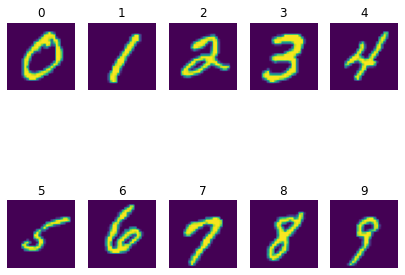

cut 60000 into  800
the shape of data after cut and flatten:  (800, 784)
the shape of data after PCA:  (800, 32)

Start Binary searching for sigma_i:
Perplexity:  30  | Binary searching for  20  times


c:\program files\python36\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)



Start to fit
3


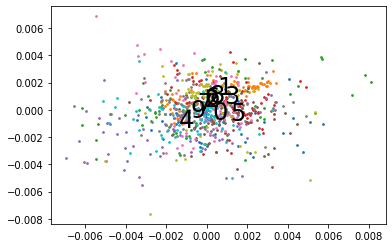

6


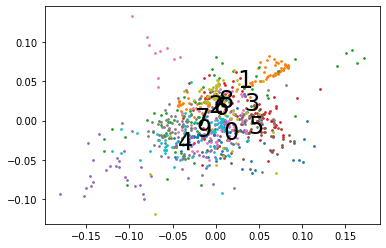

9


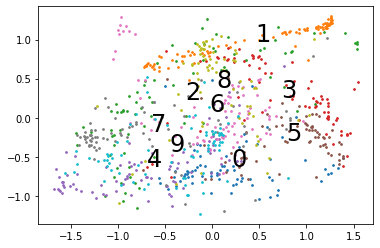

12


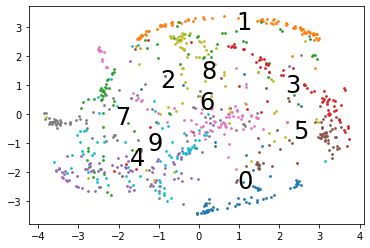

15


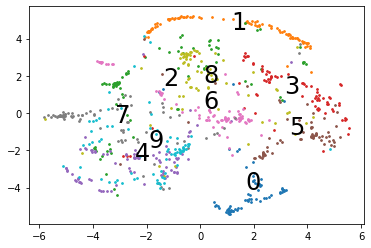

18


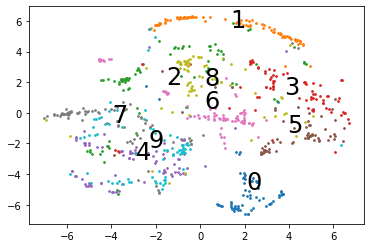

21


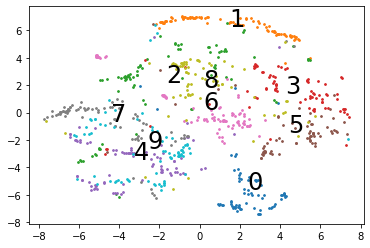

24


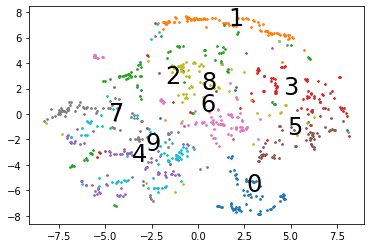

27


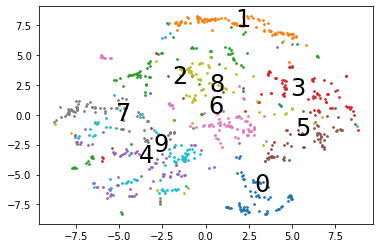

30


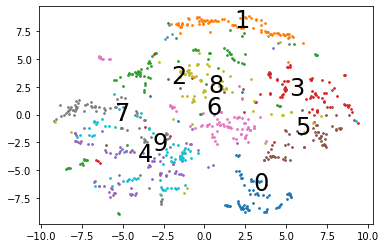

33


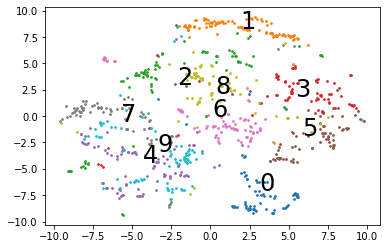

36


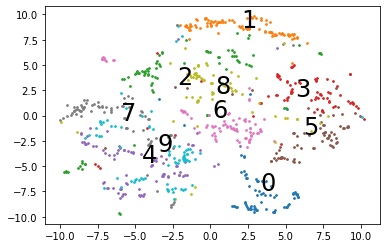

39


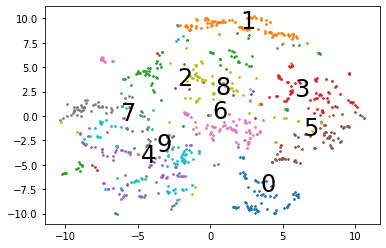

42


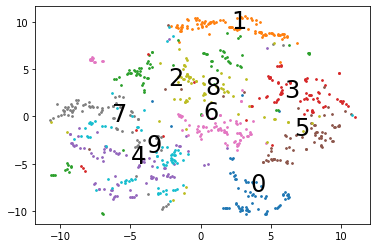

45


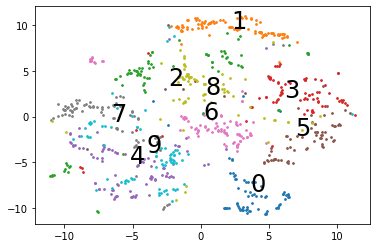

48


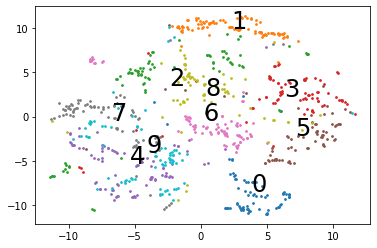

51


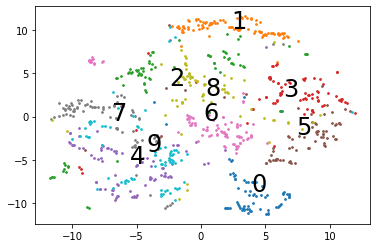

54


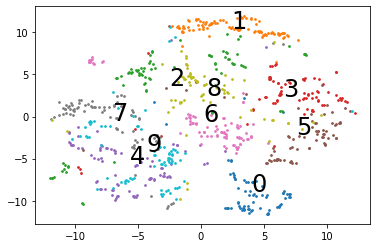

57


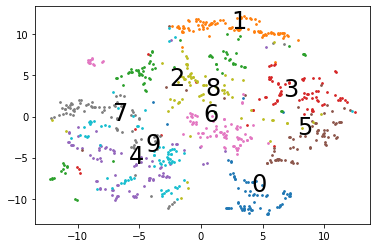

60


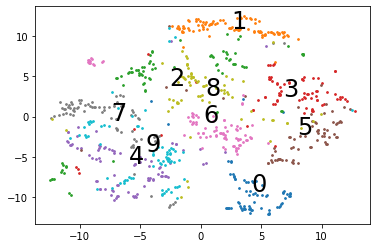

63


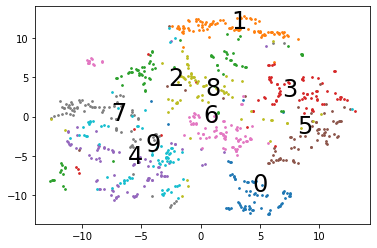

66


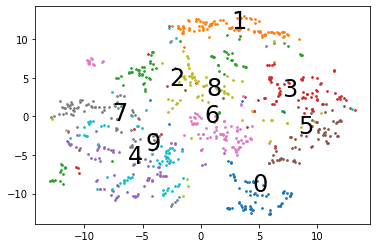

69


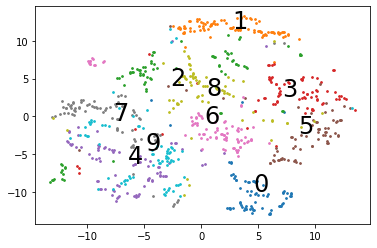

72


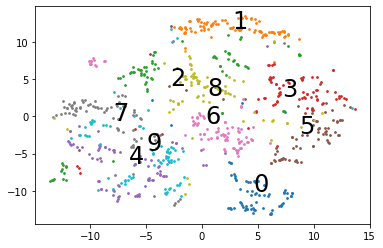

75


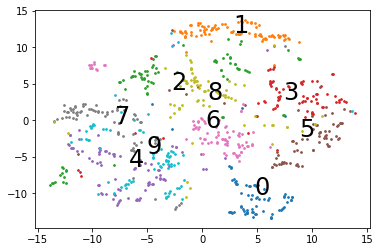

78


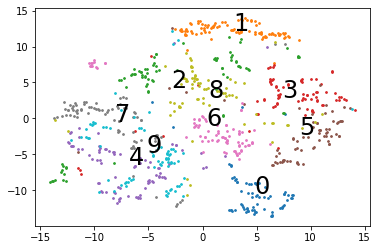

81


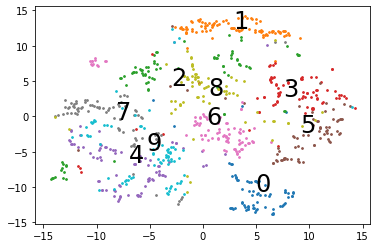

84


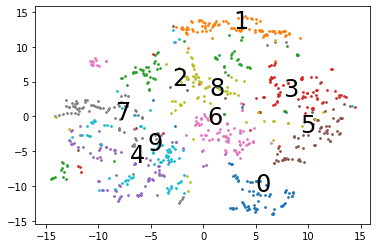

87


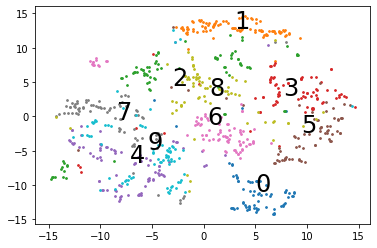

90


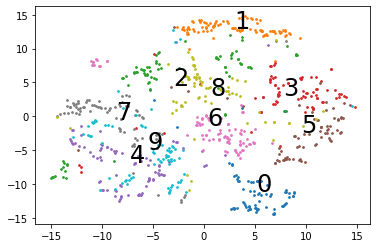

93


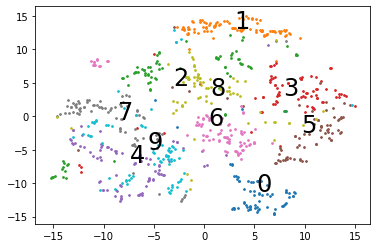

96


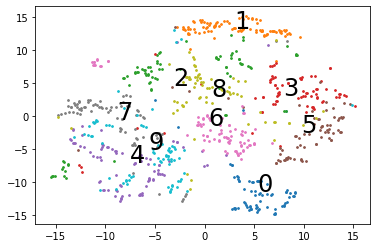

99


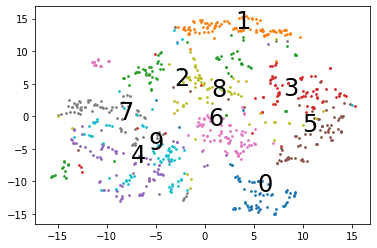

Done
Loss:


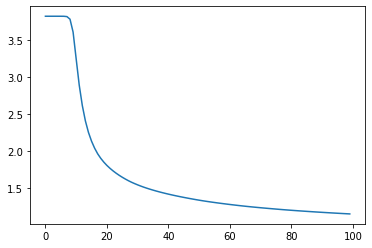

In [17]:
def run_through():
    x, indexes = read_data()
    #input()
    
    sigma = find_sigma(PERP, x)
    P_ij = count_Pij(sigma, x)
    
    if P_SYMMETRIC:
        P_ij = (P_ij + P_ij.T)/2
    if not Q_SUM_IN_RAW:
        P_ij /=SAMPLE_SIZE

    P_ij = cp.asarray(P_ij)
    
    save(saving_adr+ '/P_ij' ,P_ij)
    save(saving_adr+ '/indexes', indexes)
    
    y = tsne_fit(P_ij, indexes)

    
    
if __name__ == '__main__':
    run_through()
